In [1]:
from db.conn import DBConnector
from db.controller import *
from db.queries import query


from lib.load import load_audio_df, merge_status
from lib import speech_status, formal_status, pause_time_status, vol_corr_status

from configs import DB_info

import warnings
warnings.filterwarnings(action="ignore")

---
## 1. LOAD

In [2]:
df_audio = load_audio_df("./Data/초중등_브랜드별_영상_피치정보_최종_20230718.xlsx")
df_audio.head()

,lecture,word,time_start,time_end,size,pitch_avg
0,중학_밀크티_과학,<eps>,0,14280,1971.360,89.77
1,중학_밀크티_과학,과연,14280,14760,2482.490,261.78
2,중학_밀크티_과학,<eps>,14760,15090,288.030,233.17
3,중학_밀크티_과학,이,15090,15240,941.479,165.96
4,중학_밀크티_과학,디엔에이는,15240,16140,1982.640,228.65


In [3]:
# Input source
rdb_cursor_create(
    db_connector = DBConnector(**DB_info["localhost_rdb_source"]), 
    _query = query["create"]["input"])

Table Created


In [4]:
# Output source
rdb_cursor_create(
    db_connector = DBConnector(**DB_info["localhost_rdb_target"]),
    _query = query["create"]["output"]
)

Table Created


In [5]:
rdb_pandas_loader(
    db_connector = DBConnector(**DB_info["localhost_rdb_source"]),
    _name = "lectures",
    df = df_audio
    )

Load completed


---
### 2. Extract

In [6]:
df_audio = rdb_pandas_extractor(
    db_connector = DBConnector(**DB_info["localhost_rdb_source"]),
    _query = query["select"]["all"]
)

In [7]:
df_audio.head()

,lecture,word,time_start,time_end,size,pitch_avg
0,중학_밀크티_과학,<eps>,0,14280,1971.360,89.77
1,중학_밀크티_과학,과연,14280,14760,2482.490,261.78
2,중학_밀크티_과학,<eps>,14760,15090,288.030,233.17
3,중학_밀크티_과학,이,15090,15240,941.479,165.96
4,중학_밀크티_과학,디엔에이는,15240,16140,1982.640,228.65


---
### 3. Get outputs

In [8]:
df_speech_status = speech_status.get_speech_status(df_audio)
df_formal_status = formal_status.get_formal_status(df_audio)
df_pause_time_status = pause_time_status.get_pause_time_status(df_audio)
df_vol_corr_status = vol_corr_status.get_vol_corr_status(df_audio)

df_mid_status = merge_status(
    df_speech_status = df_speech_status,
    df_formal_status = df_formal_status,
    df_pause_time_status = df_pause_time_status,
    df_vol_corr_status = df_vol_corr_status,
    target="middle"
)

df_ele_status = merge_status(
    df_speech_status = df_speech_status,
    df_formal_status = df_formal_status,
    df_pause_time_status = df_pause_time_status,
    df_vol_corr_status = df_vol_corr_status,
    target="element"
)

[Kss]: Oh! You have konlpy.tag.Mecab in your environment. Kss will take this as a backend! :D



[Kss]: WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.10.11 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [9]:
df_mid_status

,lecture,MilkT_speech_amt,MilkT_speech_spd,MilkT_formal_prop,MilkT_pause_length,MilkT_vol_corr,Compare_speech_amt,Compare_speech_spd,Compare_formal_prop,Compare_pause_length,Compare_vol_corr
0,과학,7.319113,6.309032,0.857143,445.859729,0.371204,9.521920,7.733328,0.500000,364.615385,0.535215
1,국어,11.086913,5.660231,0.910714,513.644252,0.422222,10.562218,6.058137,0.833333,483.029703,0.327992
2,사회,11.773064,6.239173,0.896552,463.913043,0.004932,6.379277,7.018284,0.727273,423.362069,0.256102
3,수학,14.449985,5.806441,0.901408,473.250000,0.198515,9.935742,6.833984,0.826087,394.219235,0.403711
4,영어,13.587508,6.381560,0.761194,428.375912,0.256206,9.685230,6.353318,0.891304,408.483871,0.495165


In [10]:
df_ele_status

,lecture,MilkT_speech_amt,MilkT_speech_spd,MilkT_formal_prop,MilkT_pause_length,MilkT_vol_corr,Compare_speech_amt,Compare_speech_spd,Compare_formal_prop,Compare_pause_length,Compare_vol_corr
0,국어,11.067194,6.700736,0.885714,444.916944,0.180359,8.897070,6.725216,0.758621,413.982808,0.281251
1,과학,6.950880,5.607776,0.866667,500.000000,0.269381,5.245589,6.146491,0.727273,451.257485,0.381762
2,수학,5.958055,5.965700,0.800000,395.114754,0.343600,11.010617,5.731652,0.910714,463.655914,0.378360


---
### 4. Load

In [11]:
rdb_pandas_loader(
    db_connector = DBConnector(**DB_info["localhost_rdb_target"]),
    _name = "results",
    df = df_mid_status
)

Load completed


In [12]:
df_mid_status = rdb_pandas_extractor(
    db_connector = DBConnector(**DB_info["localhost_rdb_target"]),
    _query = query["select"]["results"]
)

In [13]:
df_mid_status

,lecture,MilkT_speech_amt,MilkT_speech_spd,MilkT_formal_prop,MilkT_pause_length,MilkT_vol_corr,Compare_speech_amt,Compare_speech_spd,Compare_formal_prop,Compare_pause_length,Compare_vol_corr
0,과학,7.319113,6.309032,0.857143,445.859729,0.371204,9.521920,7.733328,0.500000,364.615385,0.535215
1,국어,11.086913,5.660231,0.910714,513.644252,0.422222,10.562218,6.058137,0.833333,483.029703,0.327992
2,사회,11.773064,6.239173,0.896552,463.913043,0.004932,6.379277,7.018284,0.727273,423.362069,0.256102
3,수학,14.449985,5.806441,0.901408,473.250000,0.198515,9.935742,6.833984,0.826087,394.219235,0.403711
4,영어,13.587508,6.381560,0.761194,428.375912,0.256206,9.685230,6.353318,0.891304,408.483871,0.495165


---
### 4. Plot results

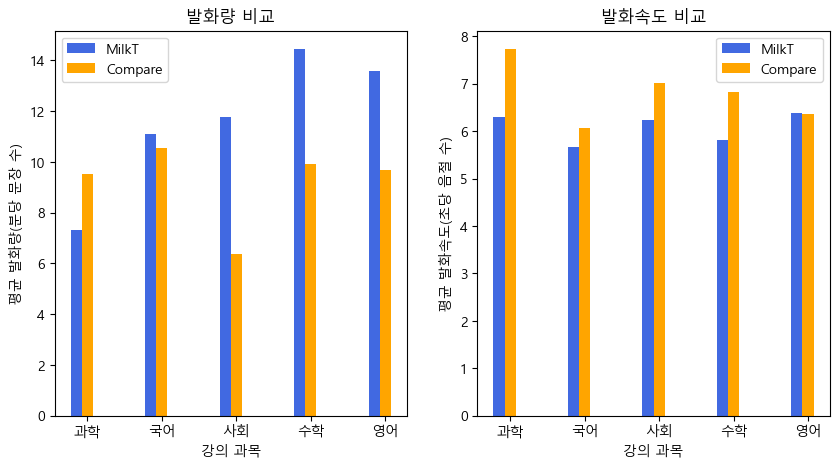

In [8]:
speech_status.plot_speech_info(df_mid_status)

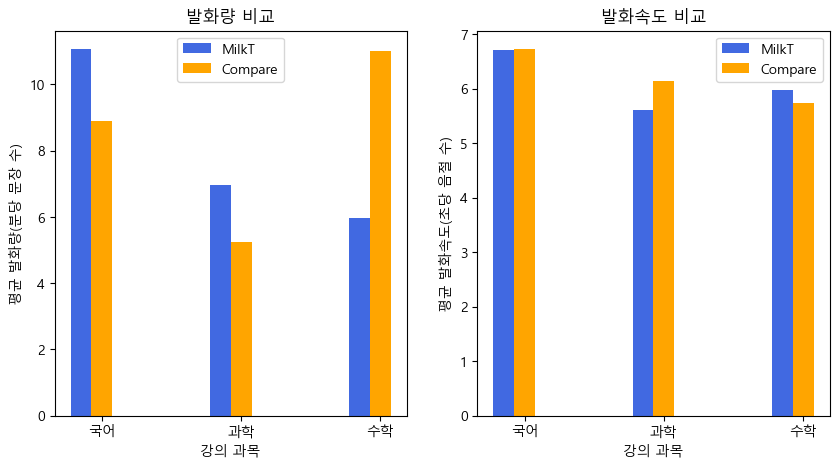

In [9]:
speech_status.plot_speech_info(df_ele_status)

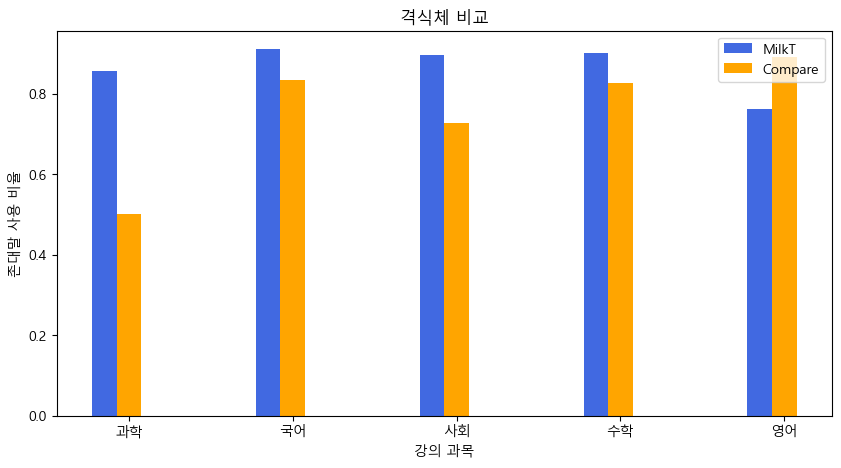

In [10]:
formal_status.plot_formal_info(df_mid_status)

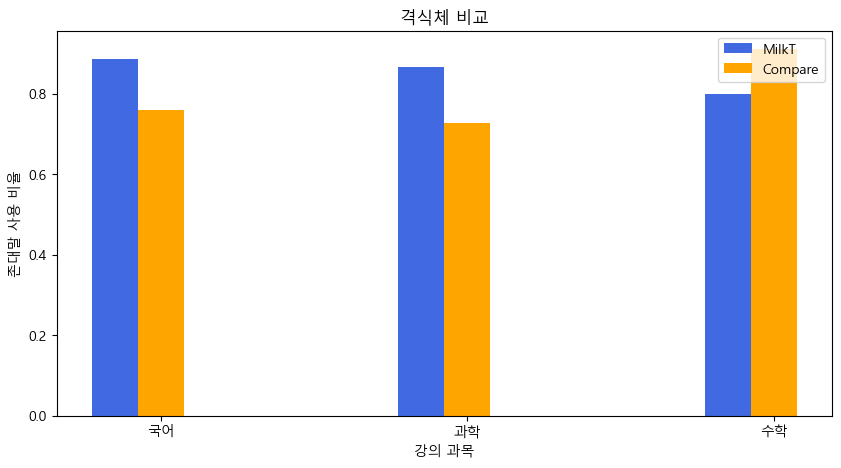

In [11]:
formal_status.plot_formal_info(df_ele_status)

In [ ]:
def get_pitch_change(df):   
    new_df = df.copy()
    unique_lecs = new_df["lecture"].unique()

    pitch_change = []
    for lec in unique_lecs:
        pitch_avg = new_df[new_df["lecture"] == lec]["pitch_avg"]
        gamma = np.insert(np.diff(pitch_avg), 0, 0).tolist()
        pitch_change.append(gamma)

    new_df["pitch_change"] = np.abs(list(itertools.chain(*pitch_change)))
    
    return new_df

In [ ]:
df_wo_eps_new = get_pitch_change(df_wo_eps)
df_wo_eps_new.head()

,lecture,word,time_start,time_end,size,pitch_avg,pitch_change
1,중학_밀크티_과학,과연,14280,14760,2482.490,261.78,0.00
3,중학_밀크티_과학,이,15090,15240,941.479,165.96,95.82
4,중학_밀크티_과학,디엔에이는,15240,16140,1982.640,228.65,62.69
6,중학_밀크티_과학,어디,16230,16560,1897.880,168.93,59.72
7,중학_밀크티_과학,있을까요,16560,17130,2221.390,136.43,32.50
